# First Practical work

* Name Student 1: 
* NIA Student 1:
* Name Student 2:
* NIA Student 2:
  
This is second practical work skeleton.

It is divided in 3 parts_

1.   Python module load section: load all the needed modules
2.   Google Drive access and mounting
3.   Host load data






## Module load section
We will install the pycuda module in the colaboratory environment, to combine python and CUDA in our code. Because pycuda is not available by default, this task can take a few minutes.

As well we load numpy and matplotlib modules.

In [718]:
!pip install nibabel

We import the Python modules which we will use in the notebook (numpy, pycuda and time module) 

In [719]:
import  numpy  as  np
from sys import getsizeof
import time
from os.path import join

In [720]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile

In [721]:
import nibabel as nib

In [722]:
# import your_library here

# Three-dimensional filtering

The objective of the practice is to implement a three-dimensional filtering of information (usually a 3-dimensional image coming from, for example, medical images) to which a preprocessing must be performed for further analysis.

Due to technical limitations, we will assume that the filtering function is a cube of 3x3 voxels (or three-dimensional pixel) and the image will have a maximum size of 1Gbyte (1024x1024x1024), although it will not necessarily be cubic.

## How to filter a voxel?
To filter a voxel we select the coordinates of the voxel we want to filter and the surrounding neighbors in the 3 dimensions (for a 3x3 filter the coefficient corresponding to the voxel to be filtered corresponds to the positions (1,1,1) of the filter mask).
The n selected neighbors are multiplied by the corresponding coefficients in the filter mask, around the selected voxel, and the products are summed, as in the case of 2-dimensional filters.

The result of this sum is the value assigned to the selected position of the resulting voxel.

## Cases at the edges
To calculate the filtered voxel at a position corresponding to one of the edges of the image, we replicate that layer, so that the data of the missing layer is equal to that of the layer to be filtered.
In the case of edges or corners, the value of the corresponding corner is replicated.

## Clapping
The resulting data will be an floating point 32bits data.

## Mount Google Drive and access grant
This part could be used to access to your Google Drive Data, **ONLY IF YOU ARE USING GOOGLE COLABORATORY**. Otherwise leave commented out. 

For security and privacy reasons, this permission is temporally, and will be requested every time you restart the notebook. 

Your Google Drive will be mounted in the "/content/drive" folder. The first Folder will be "My Drive".

You have to copy your images to a folder in the "My Drive" folder in your Google Drive.

To check your available files, use the cell indicated as "**List Files in Folder**"

In [723]:
# 
# from google.colab import drive
# drive.mount("/content/drive")

In [724]:
# !ls /content/drive/My\ Drive/images

## IMAGES DEFINITION

The follow MYDRIVE variable will be used to address where are stored the images files.

Please, change it to your correct location.

All the images should be refered to this directory.

In [725]:
MYDRIVE="./"

We define a variable IMAGE which is constructed joining the "MYDRIVE" varible plus the final path to your image.

In [726]:
#IMAGE=join(MYDRIVE,HERE YOU HAVE TO WRITE THE IMAGE TO LOAD)

In [727]:
IMAGE=join(MYDRIVE,'someones_epi.nii.gz')

In [728]:
print("Image to load: {0}".format(IMAGE))

Image to load: ./someones_epi.nii.gz


Loads an image in a numpy variable, and show.

In [729]:
epi_img = nib.load(IMAGE)
epi_img_data = epi_img.get_fdata().astype(np.float32)
epi_img_data.shape

(53, 61, 33)

In [730]:
epi_img_data_final = epi_img_data.T

In [731]:
epi_img_data_final.shape

(33, 61, 53)

In [732]:
epi_img_data.dtype

dtype('float32')

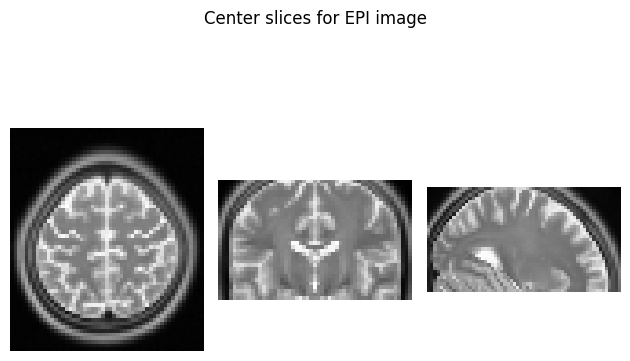

In [733]:
import matplotlib.pyplot as plt

def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    if len(slices) == 1:
        axes = [axes]  # Make axes iterable
    for i, slice in enumerate(slices):
        axes[i].imshow(slice, cmap="gray", origin="lower")
        axes[i].axis('off')  # Hide axis for better display
    plt.tight_layout()
    return fig, axes

slice_0 = epi_img_data_final[26, :, :]
slice_1 = epi_img_data_final[:, 30, :]
slice_2 = epi_img_data_final[:, :, 16]

fig, axes = show_slices([slice_0, slice_1, slice_2])
fig.suptitle("Center slices for EPI image")
plt.show()

## FILTERS DEFINITION

Here we defines our sample filter masks.

In [734]:
#This is an identity filter: the resulting
filter1=np.zeros((3,3,3),dtype=np.float32)
filter1[1,1,1] =1.0

In [735]:
#This is an edge detector filter in xy axis filter: the resulting
filter2=np.zeros((3,3,3),dtype=np.float32)
filter2[0,0,1] = -0.25
filter2[2,0,1] = -0.25
filter2[0,2,1] = 0.25
filter2[2,2,1] = 0.25

In [736]:
#This is an edge detector filter in xz axis: the resulting
filter3=np.zeros((3,3,3),dtype=np.float32)
filter3[0,1,0] = -0.25
filter3[2,1,0] = -0.25
filter3[0,1,2] = 0.25
filter3[2,1,2] = 0.25

# YOUR CODE

In [737]:
import multiprocessing as mp
from multiprocessing import Pool
from multiprocessing import shared_memory
from functools import partial

# Set start method to 'fork' for macOS compatibility
try:
    mp.set_start_method('fork', force=True)
except RuntimeError:
    pass  # Already set


## SETUP EXPERIMENT

Recover the image shape, and select the two first items (rows and columns).

In [738]:
image_shape=epi_img_data_final.shape

In [739]:
def apply_3d_filter_at_position(image, filter_mask, x, y, z, shape):
    depth, height, width = shape
    total = 0.0
    for dz in (-1, 0, 1):
        z_neighbor = z + dz
        z_f = dz + 1
        # clamp neighbor, not center
        z_c = 0 if z_neighbor < 0 else (depth - 1 if z_neighbor >= depth else z_neighbor)

        for dy in (-1, 0, 1):
            y_neighbor = y + dy
            y_f = dy + 1
            y_c = 0 if y_neighbor < 0 else (height - 1 if y_neighbor >= height else y_neighbor)

            for dx in (-1, 0, 1):
                x_neighbor = x + dx
                x_f = dx + 1
                x_c = 0 if x_neighbor < 0 else (width - 1 if x_neighbor >= width else x_neighbor)

                voxel_value = float(image[z_c, y_c, x_c])
                total += voxel_value * float(filter_mask[z_f, y_f, x_f])
    return total

In [740]:
def process_z_layer(z, shm_name, image_shape, filter_mask, input_image):
    """
    Process a single Z layer (parallelized along Z axis as suggested).
    This function will be called by each parallel process.
    
    Parameters:
    - z: Z coordinate of the layer to process
    - shm_name: Name of the shared memory block
    - image_shape: Shape of the image
    - filter_mask: 3x3x3 filter to apply
    - input_image: The input image array
    """
    # Access shared memory
    existing_shm = shared_memory.SharedMemory(name=shm_name)
    output_array = np.ndarray(image_shape, dtype=np.float32, buffer=existing_shm.buf)
    
    depth, height, width = image_shape
    
    # Process all voxels in this Z layer sequentially
    for y in range(height):
        for x in range(width):
            # Apply filter at this position
            filtered_value = apply_3d_filter_at_position(
                input_image, filter_mask, x, y, z, image_shape
            )
            # Store result in shared memory
            output_array[z, y, x] = filtered_value
    
    # Close shared memory access (don't unlink, that's done by main process)
    existing_shm.close()


def parallel_3d_filter(input_image, filter_mask, num_processes=None):
    """
    Apply 3D filter in parallel using multiprocessing.
    Parallelizes along Z axis as suggested in the assignment.
    
    Parameters:
    - input_image: 3D numpy array to filter
    - filter_mask: 3x3x3 filter
    - num_processes: Number of parallel processes (default: CPU count)
    
    Returns:
    - filtered_image: 3D numpy array with filtered result
    """
    if num_processes is None:
        num_processes = mp.cpu_count()
    
    image_shape = input_image.shape
    depth, height, width = image_shape
    
    # Create shared memory for output
    shm = shared_memory.SharedMemory(create=True, size=input_image.nbytes)
    filtered_image_shm = np.ndarray(image_shape, dtype=np.float32, buffer=shm.buf)
    
    # Initialize with zeros
    filtered_image_shm[:] = 0
    
    print(f"Starting parallel filtering with {num_processes} processes...")
    print(f"Processing {depth} Z layers in parallel...")
    
    # Create pool of workers
    with Pool(processes=num_processes) as pool:
        # Create partial function with fixed parameters
        process_func = partial(
            process_z_layer,
            shm_name=shm.name,
            image_shape=image_shape,
            filter_mask=filter_mask,
            input_image=input_image
        )
        
        # Map each Z layer to a process
        pool.map(process_func, range(depth))
    
    # Copy result from shared memory
    result = filtered_image_shm.copy()
    
    # Cleanup
    shm.close()
    shm.unlink()
    
    return result

In [741]:
def sequential_3d_filter(input_image, filter_mask):
    """
    Sequential (non-parallel) implementation for comparison.
    """
    image_shape = input_image.shape
    depth, height, width = image_shape
    
    filtered_image = np.zeros(image_shape, dtype=np.float32)
    
    for z in range(depth):
        for y in range(height):
            for x in range(width):
                filtered_value = apply_3d_filter_at_position(
                    input_image, filter_mask, x, y, z, image_shape
                )
                filtered_image[z, y, x] = filtered_value
    
    return filtered_image

Allocates the target image memory.

In [742]:
# filtered_image_shm = Array('f', int(np.prod(image_shape)))

### The next lines is only valid for the filter mask filter1, in order to check if the image was readed correct

*NOTE* The follow code fetch from the stack the exectution statistics produced by the magic metacommand %%timeit and stores it in a python variable.

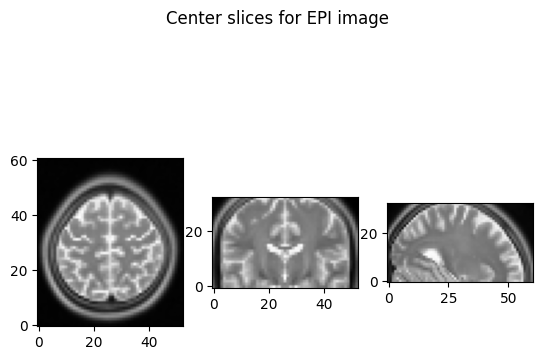

In [743]:
import matplotlib.pyplot as plt

def show_slices(slices):

   """ Function to display row of image slices """

   fig, axes = plt.subplots(1, len(slices))

   for i, slice in enumerate(slices):

       axes[i].imshow(slice, cmap="gray", origin="lower")


slice_0 = epi_img_data_final[26, :, :]
slice_1 = epi_img_data_final[:, 30, :]
slice_2 = epi_img_data_final[:, :, 16]

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")
plt.show()

In [744]:
from pathlib import Path

# CONCLUSIONS

In [745]:
import os
import time
from pathlib import Path

import numpy as np
from PIL import Image

# Lazy import nibabel only if needed (so PNG/JPEG users don't need it installed)
def _load_nifti(filepath: Path) -> np.ndarray:
    import nibabel as nib  # imported here to avoid hard dependency if not used
    img = nib.load(str(filepath))
    data = img.get_fdata().astype(np.float32)
    # Return as Z,Y,X (common for simple 3D ops). Remove .T if you want native orientation.
    return np.asarray(data)

def load_image_data(filepath: str | Path) -> np.ndarray:
    """
    Load image data and return as a 3D NumPy array (Z, Y, X).
    Supports:
      - .nii.gz / .nii (NIfTI) -> full 3D volume
      - .png / .jpg / .jpeg (2D) -> converted to grayscale and expanded with Z=1
    """
    p = Path(filepath)
    if not p.exists():
        raise FileNotFoundError(f"File not found: {p}")

    suffixes = "".join(p.suffixes).lower()

    if suffixes.endswith(".nii.gz") or suffixes.endswith(".nii"):
        # 3D NIfTI
        vol = _load_nifti(p)
        if vol.ndim == 2:
            # rare, but make it 3D
            vol = vol[np.newaxis, :, :]
        elif vol.ndim == 3:
            # already 3D
            pass
        else:
            raise ValueError(f"Unsupported NIfTI shape {vol.shape} (expected 2D or 3D).")
        return vol.astype(np.float32)

    elif p.suffix.lower() in {".png", ".jpg", ".jpeg"}:
        # 2D image -> grayscale -> add Z dimension
        img = Image.open(p)
        img_array = np.array(img.convert("L"), dtype=np.float32)  # (Y, X)
        img_3d = img_array[np.newaxis, :, :]                      # (Z=1, Y, X)
        return img_3d

    else:
        raise ValueError(f"Unsupported file format: {p.name}")

if __name__ == "__main__":
    # ---- CHANGE THESE TO YOUR FILES ----
    EPI_IMAGE_PATH = "./someones_anatomy.nii.gz"        # or "./image.png"
    ANATOMY_IMAGE_PATH = "./someones_epi.nii.gz"  # or "./image.png"
    # ------------------------------------
    print("=== Loading Images ===")
    epi_img_data_final = load_image_data(EPI_IMAGE_PATH)
    # epi_img_data_final = np.random.rand(10, 10, 10).astype(np.float32)

    print(f"Loaded EPI image with shape: {epi_img_data_final.shape}")

    anatomy_img_data_final = load_image_data(ANATOMY_IMAGE_PATH)
    # anatomy_img_data_final = np.random.rand(10, 10, 10).astype(np.float32)
    print(f"Loaded Anatomy image with shape: {anatomy_img_data_final.shape}")



    print("\n=== Testing with Identity Filter (filter1) ===")
    print("Testing with identity filter (filter1)...")
    start_time = time.time()
    filtered_image = parallel_3d_filter(epi_img_data_final, filter1)
    end_time = time.time()
    parallel_time = end_time - start_time
    print(f"Parallel execution time: {parallel_time:.4f} seconds")

    print("\nVerifying identity filter result...")
    is_close = np.allclose(filtered_image, epi_img_data_final, rtol=1e-5, atol=1e-5)
    print(f"Result matches input: {is_close}")
    if not is_close:
        max_diff = float(np.max(np.abs(filtered_image - epi_img_data_final)))
        print(f"Maximum difference: {max_diff}")

    print("\n=== Testing with XY Edge Detection Filter (filter2) ===")
    start_time = time.time()
    filtered_image_edges_xy = parallel_3d_filter(epi_img_data_final, filter2)
    end_time = time.time()
    print(f"Parallel execution time: {end_time - start_time:.4f} seconds")

    print("\n=== Testing with XZ Edge Detection Filter (filter3) ===")
    start_time = time.time()
    filtered_image_edges_xz = parallel_3d_filter(epi_img_data_final, filter3)
    end_time = time.time()
    print(f"Parallel execution time: {end_time - start_time:.4f} seconds")

    print("\n=== Performance Comparison ===")
    print("Running sequential version for comparison...")

    # Use a smaller subset for sequential timing if image is large
    if epi_img_data_final.shape[0] > 20:
        test_subset = epi_img_data_final[:10, :, :]  # first 10 slices
        print(f"Using subset of shape {test_subset.shape} for sequential test")
    else:
        test_subset = epi_img_data_final
        print(f"Using full image of shape {test_subset.shape}")

    start_time = time.time()
    filtered_sequential = sequential_3d_filter(test_subset, filter1)
    end_time = time.time()
    sequential_time = end_time - start_time
    print(f"Sequential execution time: {sequential_time:.4f} seconds")

    # Estimate speedup (extrapolate if using subset)
    if test_subset.shape[0] < epi_img_data_final.shape[0]:
        scale_factor = epi_img_data_final.shape[0] / test_subset.shape[0]
        estimated_full_sequential = sequential_time * scale_factor
        print(f"Estimated full sequential time: {estimated_full_sequential:.4f} seconds")
        speedup = estimated_full_sequential / max(parallel_time, 1e-9)
    else:
        speedup = sequential_time / max(parallel_time, 1e-9)

    print(f"\nSpeedup: {speedup:.2f}x")

    print("\n=== Timing Statistics (5 runs) ===")
    times = []
    for i in range(5):
        start = time.time()
        _ = parallel_3d_filter(epi_img_data_final, filter1)
        end = time.time()
        times.append(end - start)
        print(f"Run {i+1}: {times[-1]:.4f} seconds")

    best_time = min(times)
    worst_time = max(times)
    avg_time = float(np.mean(times))
    std_time = float(np.std(times))

    print(f"\nBest execution time: {best_time:.4f} seconds")
    print(f"Worst execution time: {worst_time:.4f} seconds")
    print(f"Mean execution time: {avg_time:.4f} ({std_time:.4f} std dev)")

    print("\n=== Testing with Anatomy Image ===")
    start_time = time.time()
    filtered_anatomy = parallel_3d_filter(anatomy_img_data_final, filter1)
    end_time = time.time()
    print(f"Anatomy image filtered in {end_time - start_time:.4f} seconds")
    print(f"Filtered anatomy image shape: {filtered_anatomy.shape}")

    print("Are_all the values close to the same?",np.allclose(filtered_image,epi_img_data_final))


=== Loading Images ===
Loaded EPI image with shape: (57, 67, 56)
Loaded Anatomy image with shape: (53, 61, 33)

=== Testing with Identity Filter (filter1) ===
Testing with identity filter (filter1)...
Starting parallel filtering with 10 processes...
Processing 57 Z layers in parallel...
Parallel execution time: 0.2099 seconds

Verifying identity filter result...
Result matches input: True

=== Testing with XY Edge Detection Filter (filter2) ===
Starting parallel filtering with 10 processes...
Processing 57 Z layers in parallel...
Parallel execution time: 0.2120 seconds

=== Testing with XZ Edge Detection Filter (filter3) ===
Starting parallel filtering with 10 processes...
Processing 57 Z layers in parallel...
Parallel execution time: 0.2095 seconds

=== Performance Comparison ===
Running sequential version for comparison...
Using subset of shape (10, 67, 56) for sequential test
Sequential execution time: 0.1675 seconds
Estimated full sequential time: 0.9545 seconds

Speedup: 4.55x

==

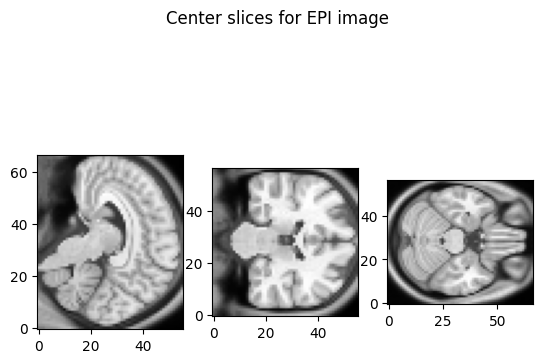

In [746]:
import matplotlib.pyplot as plt

def show_slices(slices):

   """ Function to display row of image slices """

   fig, axes = plt.subplots(1, len(slices))

   for i, slice in enumerate(slices):

       axes[i].imshow(slice, cmap="gray", origin="lower")


slice_0 = epi_img_data_final[26, :, :]
slice_1 = epi_img_data_final[:, 30, :]
slice_2 = epi_img_data_final[:, :, 16]

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")
plt.show()

In [747]:
print("Best execution time: {}".format(best_time))
print("Worst execution time: {}".format(worst_time))
print("Mean execution time: {mean} ({stdev} std dev)".format(mean=avg_time,stdev=std_time))

Best execution time: 0.20511698722839355
Worst execution time: 0.22809100151062012
Mean execution time: 0.21563758850097656 (0.0075582549850965524 std dev)
